In [1]:
import math
import time
from math import pi

import numpy as np
import pandas as pd
from numpy import sqrt
from scipy import interpolate

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

In [2]:
# Okushiri
# https://nctr.pmel.noaa.gov/benchmark/Laboratory/Laboratory_MonaiValley/index.html

bound = pd.read_csv("okushiri_boundary.csv")
initial = pd.read_csv("MonaiValley_InputWave.csv")

In [3]:
init_t = np.array(initial.t)
init_e = np.array(initial.E)
init_func = interpolate.interp1d(init_t, init_e)

x_old = np.array(bound.x.unique())
y_old = np.array(bound.y.unique())
Nx_old = len(x_old)
Ny_old = len(y_old)
dimx = max(x_old)
dimy = max(y_old)
d_old = np.zeros((Nx_old, Ny_old))

for i in range(Nx_old):
    for j in range(Ny_old):
        d_old[i, j] = bound.iloc[i * Ny_old + j].z

dx = 0.025
dy = 0.025
x = np.arange(0, dimx, dx)
y = np.arange(0, dimy, dy)
Nx = len(x)
Ny = len(y)

d_mid = np.zeros((Nx_old, Ny))
for i in range(Nx_old):
    depth_func = interpolate.interp1d(y_old, d_old[i, :], kind='linear')
    d_mid[i, :] = depth_func(y)

d = np.zeros((Nx, Ny))
for j in range(Ny):
    depth_func = interpolate.interp1d(x_old, d_mid[:, j], kind='linear')
    d[:, j] = depth_func(x)

del d_mid, Nx_old, Ny_old

H = np.max(d)
g = 9.81
c = sqrt(g * H)
dt = 0.5 / (c * sqrt(1/dx**2 + 1/dy**2))
# dt = 0.05
dimt = 50
t = np.arange(0, dimt, dt)
Nt = len(t)
S1 = dt / dx
S2 = dt / dy

E = np.zeros((Nx, Ny, Nt))
U = np.zeros((Nx + 1, Ny, Nt))
V = np.zeros((Nx, Ny + 1, Nt))

init_wave = init_func(t[:int(np.floor(25 / dt))])
A = np.max(init_wave)
U[:, :, 0] = 0
V[:, :, 0] = 0
E[0, :, 0] = 0
# E[0, :, 0] = init_wave[0]
E[:, :, 0] = np.maximum(E[:, :, 0], -d)

In [4]:
# # ## PLOT BOTTOM PROFILE ###
# x_, y_ = np.meshgrid(x, y)
# x_, y_ = x_.T, y_.T

# x__, y__ = np.meshgrid(x_old, y_old)
# x__, y__ = x__.T, y__.T


# fig = plt.figure(figsize=(7, 5))
# ax = fig.add_subplot(111, projection='3d', xlabel="x", ylabel="y")
# ax.set_zlim(np.min(-d), np.max(-d))
# ax.view_init(45, -120)
# stamp = int(15.9 / dt)
# E_masked = np.where(E[:, :, stamp] > -d, E[:, :, stamp], np.nan)
# E_masked = np.ma.masked_invalid(E_masked)
# plot = [ax.plot_surface(x__, y__, -d_old, color='C1'),
#         ax.plot_surface(x_, y_, E_masked, cmap='winter',
#                         rstride=1, cstride=1, vmin=np.min(-d), vmax=np.max(-d))]
# # plot = [ax.plot_surface(x_, y_, -d, color='C1', stride=1, cstride=1),
# #         ax.plot_surface(x_, y_, E_masked, cmap='winter', stride=1, cstride=1, vmin=np.min(-d), vmax=np.max(-d))]
# ax.set_title('Okushiri')
# ax.grid(False)


# plt.show()

In [5]:
def synolakis(u, v, e, simlength=dimt):
    p = np.zeros((Nx + 1, Ny))
    q = np.zeros((Nx, Ny + 1))
    hx = np.empty((Nx + 1, Ny))
    hy = np.empty((Nx, Ny + 1))
    orderx = np.empty((Nx - 1, Ny))
    ordery = np.empty((Nx, Ny - 1))
    iteration = int(np.floor(simlength / dt)) - 1
    e[:, :, 0] = np.maximum(e[:, :, 0], -d)
    eps = 1e-6
#     alpha = H

    i0 = 1
    for n in range(iteration):

        u0 = u[:, :, n]
        u1 = u[:, :, n + 1]
        v0 = v[:, :, n]
        v1 = v[:, :, n + 1]
        e0 = e[:, :, n]
        e1 = e[:, :, n + 1]
        
        e0[0, :] = init_wave[n]

        p_value = u0[i0 + 1:Nx, :] > 0
        n_value = u0[i0 + 1:Nx, :] < 0
        z_value = u0[i0 + 1:Nx, :] == 0

        hx[i0 + 1:Nx, :][p_value] = d[i0:Nx - 1, :][p_value] + e0[i0:Nx - 1, :][p_value]
        hx[i0 + 1:Nx, :][n_value] = d[i0 + 1:Nx, :][n_value] + e0[i0 + 1:Nx, :][n_value]
        hx[i0 + 1:Nx, :][z_value] = (d[i0:Nx - 1, :][z_value] + e0[i0:Nx - 1, :][z_value] + d[i0 + 1:Nx, :][z_value] + e0[i0 + 1:Nx, :][z_value]) / 2
        hx[i0, :] = d[i0, :] + e0[i0, :]
        hx[-1, :] = d[-1, :] + e0[-1, :]
        p[i0 + 1:Nx, :] = np.maximum(hx[i0 + 1:Nx, :], 0) * u0[i0 + 1:Nx, :]
        p[i0, :] = hx[i0, :] * u0[i0, :]
        p[-1, :] = hx[-1, :] * u0[-1, :]

        p_value = v0[:, 1:Ny] > 0
        n_value = v0[:, 1:Ny] < 0
        z_value = v0[:, 1:Ny] == 0

        hy[:, 1:Ny][p_value] = d[:, :Ny - 1][p_value] + e0[:, :Ny - 1][p_value]
        hy[:, 1:Ny][n_value] = d[:, 1:Ny][n_value] + e0[:, 1:Ny][n_value]
        hy[:, 1:Ny][z_value] = (d[:, :Ny - 1][z_value] + e0[:, :Ny - 1][z_value] + d[:, 1:Ny][z_value] + e0[:, 1:Ny][z_value]) / 2
        hy[:, 0] = d[:, 0] + e0[:, 0]
        hy[:, -1] = d[:, -1] + e0[:, -1]
        q[:, 1:Ny] = np.maximum(hy[:, 1:Ny], 0) * v0[:, 1:Ny]
        q[:, 0] = hy[:, 0] * v0[:, 0]
        q[:, -1] = hy[:, -1] * v0[:, -1]

        e1[0, :] = init_wave[n+1]
        e1[i0:, :] = e0[i0:, :] - S1 * (p[i0 + 1:, :] - p[i0:-1, :]) - S2 * (q[i0:, 1:] - q[i0:, :-1])
        h = d + e1
        
        wetx = np.zeros((Nx - 1 - i0, Ny))
        wetx[(h[i0 + 1:Nx, :] > eps) & (h[i0:Nx - 1, :] > eps)] = 1
        pb1x = wetx * (p[i0:Nx - 1, :] + p[i0 + 1:Nx, :]) / 2
        pb2x = wetx * (p[i0 + 1:Nx, :] + p[i0 + 2:Nx + 1, :]) / 2
        u_1x = wetx * ((pb1x > 0) * u0[i0:Nx - 1, :] + (pb1x < 0) * u0[i0 + 1:Nx, :])
        u_2x = wetx * ((pb2x > 0) * u0[i0 + 1:Nx, :] + (pb2x < 0) * u0[i0 + 2:Nx + 1, :])
        qb1x = wetx[:, 1:Ny - 1] * (q[i0:Nx - 1, 1:Ny - 1] + q[i0 + 1:Nx, 1:Ny - 1]) / 2
        qb2x = wetx[:, 1:Ny - 1] * (q[i0:Nx - 1, 2:Ny] + q[i0 + 1:Nx, 2:Ny]) / 2
        u_1y = wetx[:, 1:Ny - 1] * ((qb1x > 0) * u0[i0 + 1:Nx, 0:Ny - 2] + (qb1x < 0) * u0[i0 + 1:Nx, 1:Ny - 1])
        u_2y = wetx[:, 1:Ny - 1] * ((qb2x > 0) * u0[i0 + 1:Nx, 1:Ny - 1] + (qb2x < 0) * u0[i0 + 1:Nx, 2:Ny])
        hbarx = wetx * (h[i0:Nx - 1, :] + h[i0 + 1:Nx, :]) / 2
        hbarx[hbarx <= eps] = -1
        uux = np.where(hbarx > eps, (1 / hbarx) * (pb2x * u_2x - pb1x * u_1x - u0[i0 + 1:Nx, :] * (pb2x - pb1x)), 0)
        vuy = np.where(hbarx[:, 1:Ny - 1] > eps, (1 / hbarx[:, 1:Ny - 1]) * (qb2x * u_2y - qb1x * u_1y - u0[i0 + 1:Nx, 1:Ny - 1] * (qb2x - qb1x)), 0)
        uux = np.ma.fix_invalid(uux, fill_value=0).data
        vuy = np.ma.fix_invalid(vuy, fill_value=0).data
        u1[i0 + 1:Nx, 1:Ny - 1] = wetx[:, 1:Ny - 1] * (u0[i0 + 1:Nx, 1:Ny - 1] - g * S1 * (e1[i0 + 1:Nx, 1:Ny - 1] - e1[i0:Nx - 1, 1:Ny - 1]) - S1 * uux[:, 1:Ny - 1] - S2 * vuy)
        u1[i0 + 1:Nx, 0] = wetx[:, 0] * (u0[i0 + 1:Nx, 0] - g * S1 * (e1[i0 + 1:Nx, 0] - e1[i0:Nx - 1, 0]) - S1 * uux[:, 0])
        u1[i0 + 1:Nx, -1] = wetx[:, -1] * (u0[i0 + 1:Nx, -1] - g * S1 * (e1[i0 + 1:Nx, -1] - e1[i0:Nx - 1, -1]) - S1 * uux[:, -1])
        u1[i0, :] = u0[i0, :] - g * S1 * (e1[i0, :] - e1[i0 - 1, :])
        u1[-1, :] = 0
        
        wety = np.zeros((Nx, Ny - 1))
        wety[(h[:, 1:Ny] > eps) & (h[:, 0:Ny - 1] > eps)] = 1
        qb1y = wety * (q[:, 0:Ny - 1] + q[:, 1:Ny]) / 2
        qb2y = wety * (q[:, 1:Ny] + q[:, 2:Ny + 1]) / 2
        v_1y = wety * ((qb1y > 0) * v0[:, 0:Ny - 1] + (qb1y < 0) * v0[:, 1:Ny])
        v_2y = wety * ((qb2y > 0) * v0[:, 1:Ny] + (qb2y < 0) * v0[:, 2:Ny + 1])
        pb1y = wety[1:Nx - 1, :] * (p[1:Nx - 1, 0:Ny - 1] + p[1:Nx - 1, 1:Ny]) / 2
        pb2y = wety[1:Nx - 1, :] * (p[2:Nx, 0:Ny - 1] + p[2:Nx, 1:Ny]) / 2
        v_1x = wety[1:Nx - 1, :] * ((pb1y > 0) * v0[0:Nx - 2, 1:Ny] + (pb1y < 0) * v0[1:Nx - 1, 1:Ny])
        v_2x = wety[1:Nx - 1, :] * ((pb2y > 0) * v0[1:Nx - 1, 1:Ny] + (pb2y < 0) * v0[2:Nx, 1:Ny])
        hbary = wety * (h[:, 0:Ny - 1] + h[:, 1:Ny]) / 2
        hbary[hbary <= eps] = -1
        vvy = np.where(hbary > eps, (1 / hbary) * (qb2y * v_2y - qb1y * v_1y - v0[:, 1:Ny] * (qb2y - qb1y)), 0)
        uvx = np.where(hbary[1:Nx - 1, :] > eps, (1 / hbary[1:Nx - 1, :]) * (pb2y * v_2x - pb1y * v_1x - v0[1:Nx - 1, 1:Ny] * (pb2y - pb1y)), 0)
        vvy = np.ma.fix_invalid(vvy, fill_value=0).data
        uvx = np.ma.fix_invalid(uvx, fill_value=0).data
        v1[1:Nx - 1, 1:Ny] = wety[1:Nx - 1, :] * (v0[1:Nx - 1, 1:Ny] - g * S2 * (e1[1:Nx - 1, 1:Ny] - e1[1:Nx - 1, 0:Ny - 1]) - S2 * vvy[1:Nx - 1, :] - S1 * uvx)
        v1[0, 1:Ny] = wety[0, :] * (v0[0, 1:Ny] - g * S2 * (e1[0, 1:Ny] - e1[0, 0:Ny - 1]) - S2 * vvy[0, :])
        v1[-1, 1:Ny] = wety[-1, :] * (v0[-1, 1:Ny] - g * S2 * (e1[-1, 1:Ny] - e1[-1, 0:Ny - 1]) - S2 * vvy[-1, :])
        v1[:, 0] = 0
        v1[:, -1] = 0
        


    return u, v, e

In [6]:
start = time.time()
simlength = 25
U, V, E = synolakis(U, V, E, simlength)
end = time.time()
print(end-start)

219.16322565078735


<IPython.core.display.Javascript object>


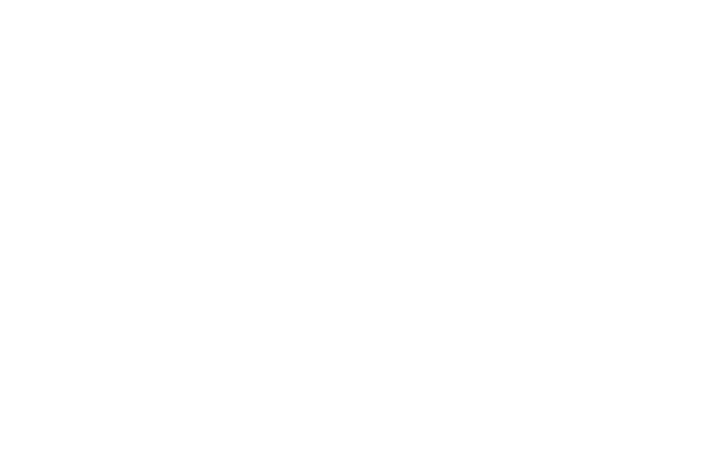

<IPython.core.display.Javascript object>


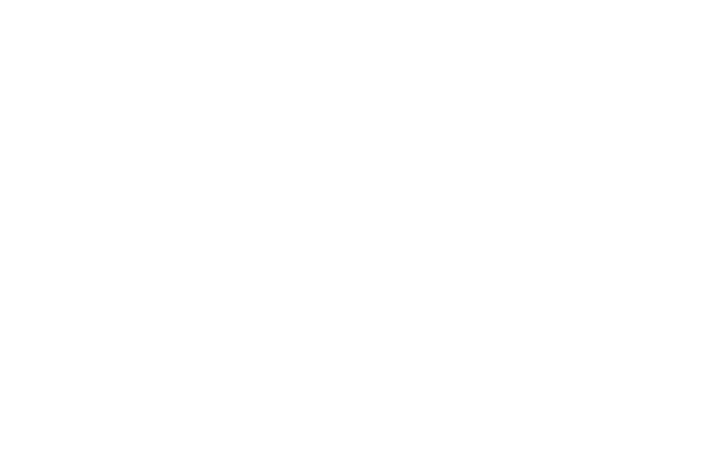

<IPython.core.display.Javascript object>


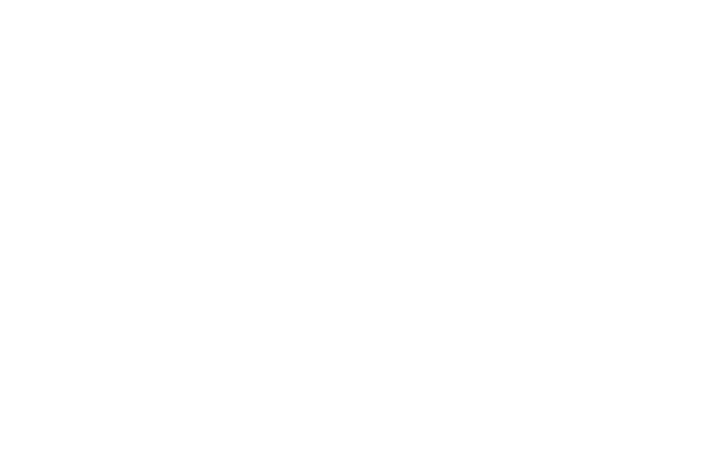

<IPython.core.display.Javascript object>


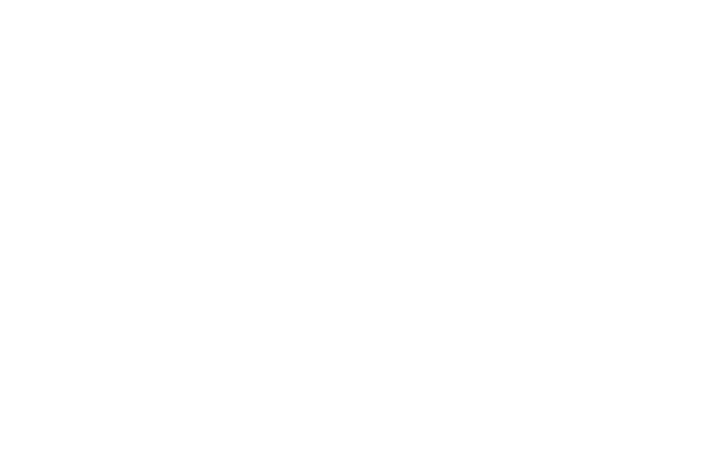

<IPython.core.display.Javascript object>


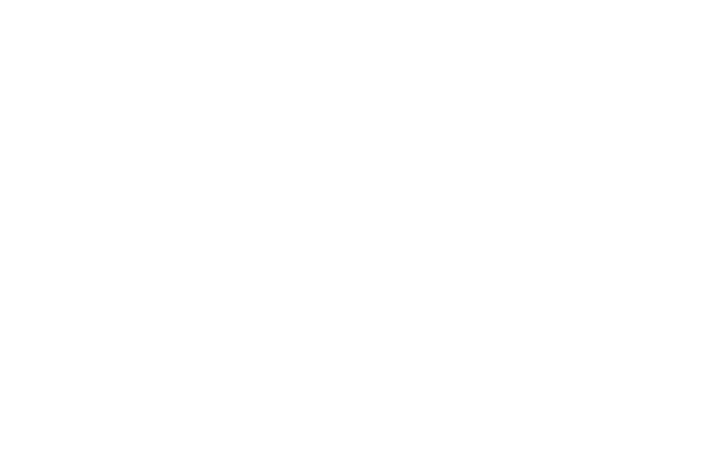

<IPython.core.display.Javascript object>


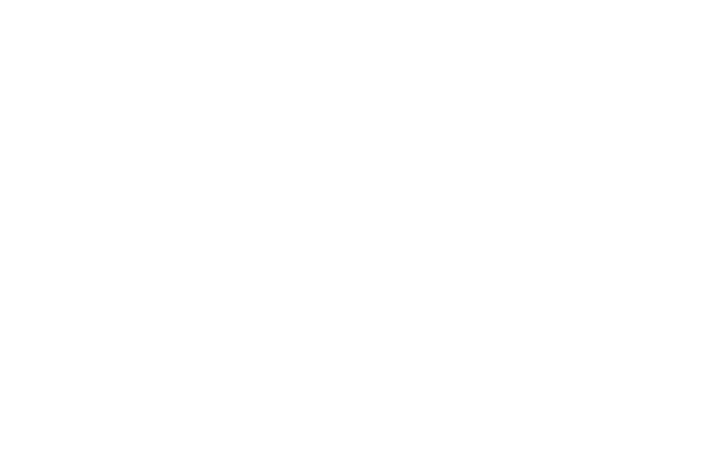

<IPython.core.display.Javascript object>


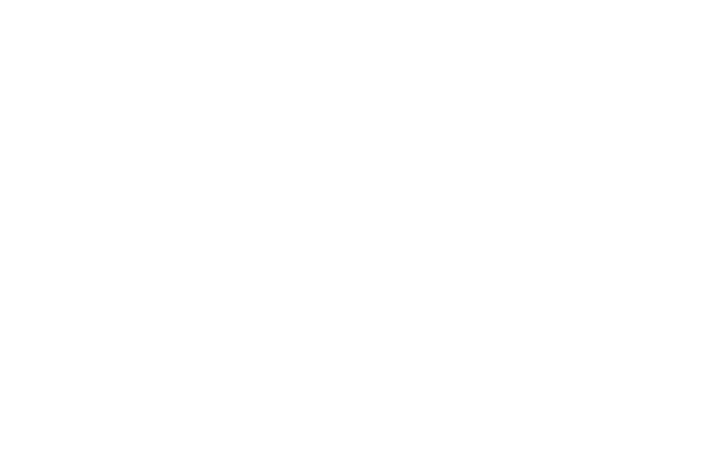

<IPython.core.display.Javascript object>


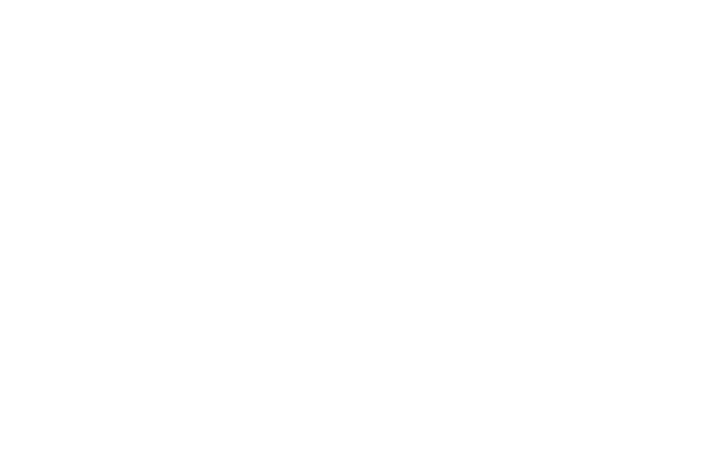

<IPython.core.display.Javascript object>


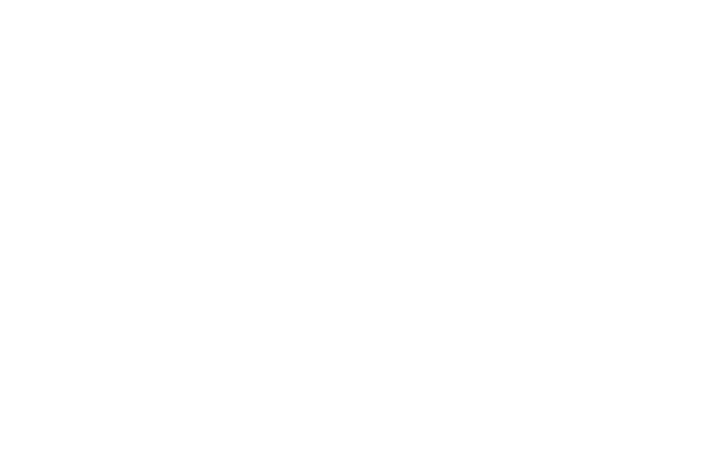

<IPython.core.display.Javascript object>


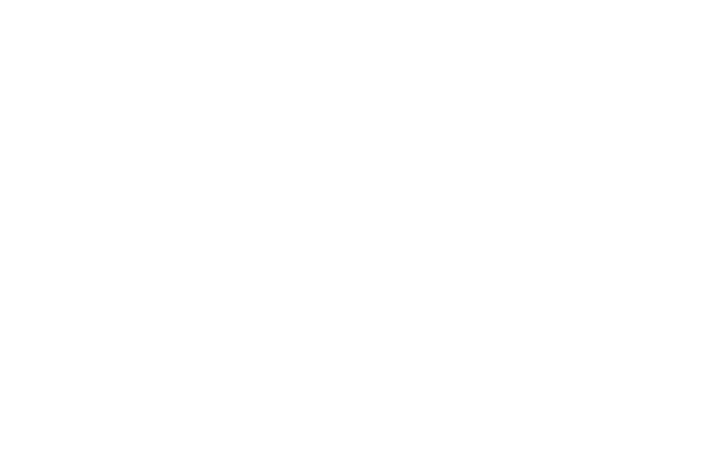

<IPython.core.display.Javascript object>


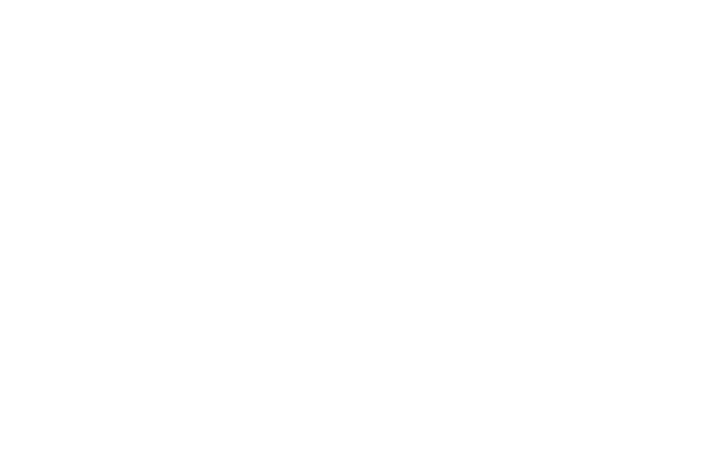

<IPython.core.display.Javascript object>


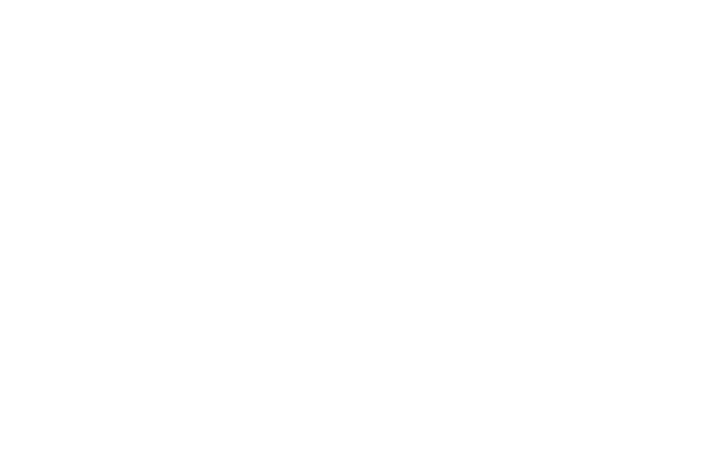

<IPython.core.display.Javascript object>


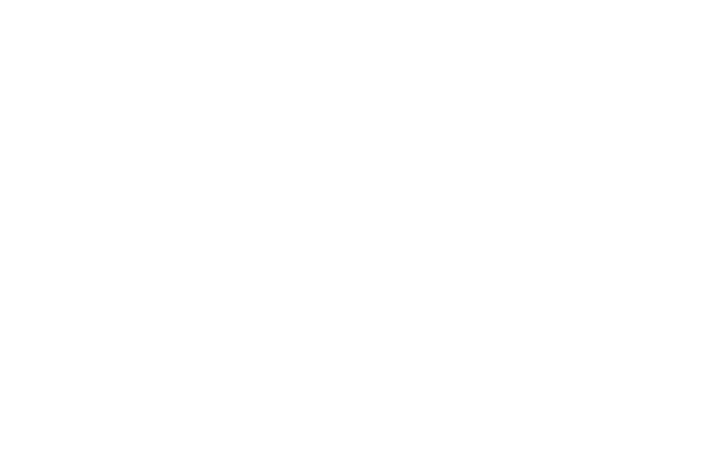

<IPython.core.display.Javascript object>


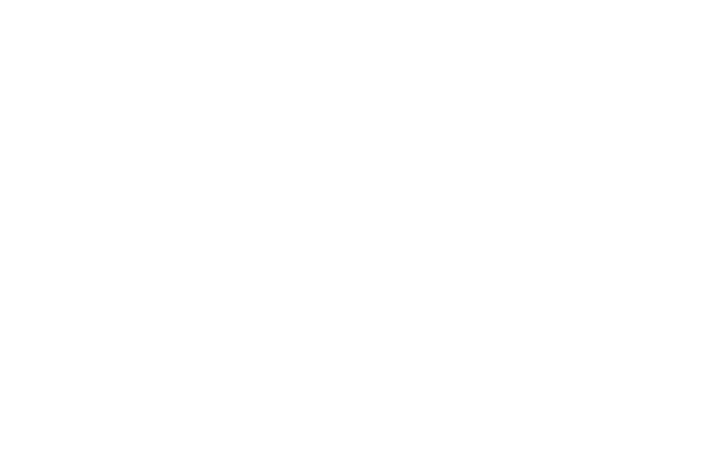

<IPython.core.display.Javascript object>


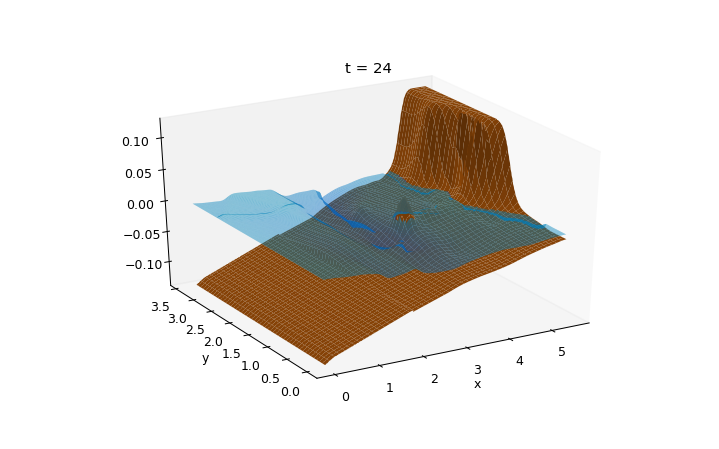

In [15]:
# ## PLOT BOTTOM PROFILE ###
x_, y_ = np.meshgrid(x, y)
x_, y_ = x_.T, y_.T

x__, y__ = np.meshgrid(x_old, y_old)
x__, y__ = x__.T, y__.T

for timestamp in range(10, 25):
    plt.close()

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d', xlabel="x", ylabel="y")
    ax.set_zlim(np.min(-d), np.max(-d))
    ax.view_init(30, -120)
    stamp = int(timestamp / dt)
    E_masked = np.where(E[:, :, stamp] > -d, E[:, :, stamp], np.nan)
    E_masked = np.ma.masked_invalid(E_masked)
    ax.plot_surface(x__, y__, -d_old, color='C1')
    ax.plot_surface(x_, y_, E_masked, cmap='winter', rstride=1, cstride=1, vmin=np.min(-d), vmax=np.max(-d), alpha=0.5)

    ax.set_title(f't = {timestamp}')
    ax.grid(False)

    plt.savefig(f'okushiri_capture_{timestamp}.png')
    # plt.show()

In [8]:
# start = time.time()

# skip = int(np.ceil(0.2 / dt))
# fps = 1 / (skip * dt)  # frame per sec
# # fps = 1 / dt  # frame per sec
# frames = int(simlength * fps)
# # frames = Nt
# zmin = np.min(-d)
# zmax = np.max(-d)

# x_, y_ = np.meshgrid(x, y)
# x_, y_ = x_.T, y_.T


# def update_plot(frame_number, z_, plot):
#     n = frame_number * skip
# #     n = frame_number
#     ax.view_init(45, -120)
#     z_masked = np.where(z_[:, :, n] > -d, z_[:, :, n], np.nan)
#     z_masked = np.ma.masked_invalid(z_masked)
#     plot[0].remove()
#     plot[0] = ax.plot_surface(x_, y_, -d, color='C1')
#     plot[1].remove()
#     plot[1] = ax.plot_surface(x_, y_, z_masked, cmap='winter',
#                               rstride=1, cstride=1, vmin=np.min(-d), vmax=np.max(-d))
# #     return plot


# fig = plt.figure(figsize=(7, 5))
# ax = fig.add_subplot(111, projection='3d', xlabel='x', ylabel='y')
# ax.set_zlim(zmin, zmax)
# ax.view_init(45, -120)
# E_masked = np.where(E[:, :, 0] > -d, E[:, :, 0], np.nan)
# E_masked = np.ma.masked_invalid(E_masked)
# plot = [ax.plot_surface(x_, y_, -d, color='C1'),
#         ax.plot_surface(x_, y_, E_masked, cmap='winter',
#                         rstride=1, cstride=1, vmin=np.min(-d), vmax=np.max(-d))]
# ani = animation.FuncAnimation(fig, update_plot, frames=frames, fargs=(E, plot), interval=1000 / fps, blit = True)


# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=fps)
# fn = 'okushiri_animation' + str(int(simlength))
# ani.save(fn+'.mp4', writer=writer)
# plt.close()

# end = time.time()
# print(end-start)

# # plt.rcParams['animation.html'] = 'html5'
# # ani

# # plt.show()